## DCGAN (Deep CNN GAN)

In [1]:
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf

In [2]:
latent_dim = 32
height = 32
width = 32
channels = 3

In [3]:
# generator
generator_input = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

out_g = layers.Conv2D(channels, 7 , activation='sigmoid', padding='same')(x)
generator = tf.keras.models.Model(generator_input, out_g)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

In [ ]:
# discriminator
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)

out_d = layers.Dense(1, activation='sigmoid')(x)

discriminator = tf.keras.models.Model(discriminator_input, out_d)
discriminator.summary()

In [5]:
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,loss='binary_crossentropy')

In [ ]:
gan_input = tf.keras.Input(shape=(latent_dim,))
img_f = generator(gan_input)
discriminator.trainable = False

gan_output = discriminator(img_f)
gan = tf.keras.models.Model(gan_input, gan_output)

gan_optimizer = tf.keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')
gan.summary()

In [8]:
import os
from tensorflow.keras.preprocessing import image

In [11]:
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


In [12]:
x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

In [13]:
x_train.shape

(5000, 32, 32, 3)

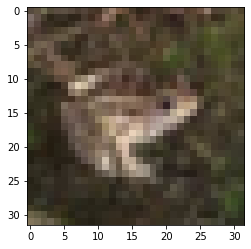

In [26]:
import matplotlib.pyplot as plt
plt.imshow(x_train[2])

In [19]:
iterations = 8000
batch_size = 20
start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([real_images, generated_images])
    
    y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    #Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, y)
    
    #sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    #Assemble labels that say 'all real images'
    misleading_targets = np.ones((batch_size, 1))
    
    #Train th generator (via the gan model, where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    
    #Occasionally save / plot
    if (step+1) % 100 == 0:
        print('discriminator loss at step %s: %s'%((step+1), d_loss))
        print('adversarial loss at step %s: %s'%((step+1, a_loss)))

discriminator loss at step 100: 0.6522265076637268
adversarial loss at step 100: 0.8703548312187195
discriminator loss at step 200: 0.6963493227958679
adversarial loss at step 200: 0.7462162375450134
discriminator loss at step 300: 0.6934767961502075
adversarial loss at step 300: 0.7098760008811951
discriminator loss at step 400: 0.6951075792312622
adversarial loss at step 400: 0.7156950235366821
discriminator loss at step 500: 0.6940481066703796
adversarial loss at step 500: 0.6833919286727905
discriminator loss at step 600: 0.6864880919456482
adversarial loss at step 600: 0.7095654606819153
discriminator loss at step 700: 0.695469856262207
adversarial loss at step 700: 0.692751407623291
discriminator loss at step 800: 0.6883177161216736
adversarial loss at step 800: 0.7293812036514282
discriminator loss at step 900: 0.7015802264213562
adversarial loss at step 900: 0.7222377061843872
discriminator loss at step 1000: 0.6916587352752686
adversarial loss at step 1000: 0.7198373079299927


In [ ]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))
# random_latent_vectors.shape
# a = image.array_to_img(random_latent_vectors * 255., scale=False)
# plt.imshow(a)
random_latent_vectors

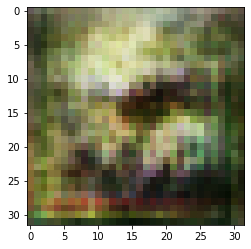

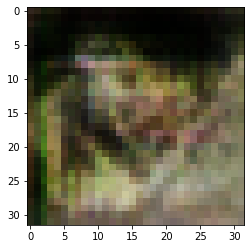

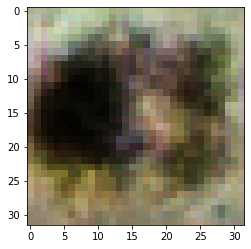

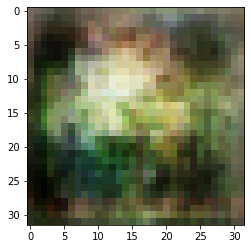

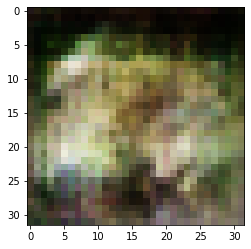

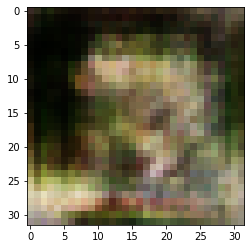

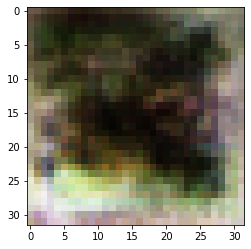

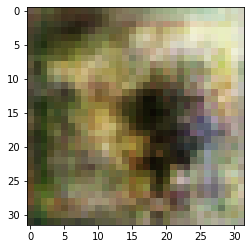

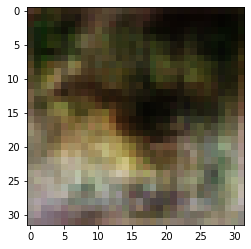

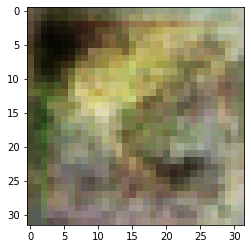

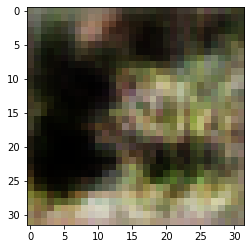

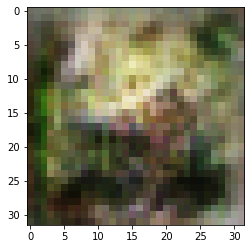

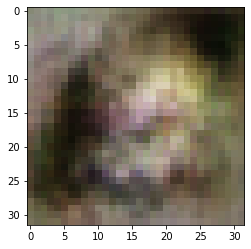

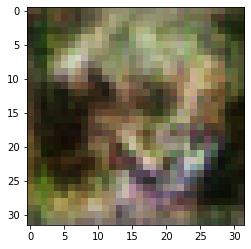

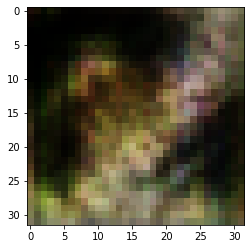

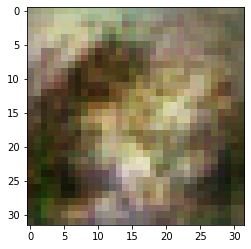

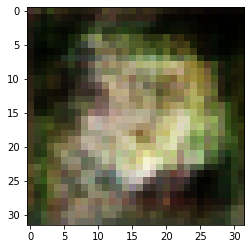

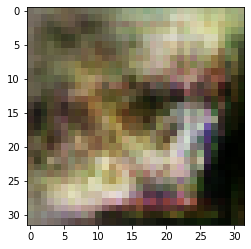

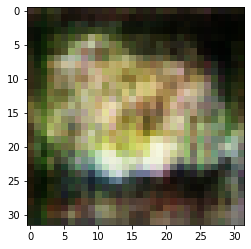

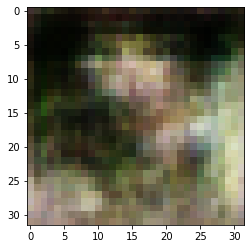

In [24]:

generatoed_images = generator.predict(random_latent_vectors)
for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
plt.show()